1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성합니다.

In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ace17f68550>)

In [3]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [4]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 (RGB 순서 )
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

# 인물 모드 사진 - 아웃포커싱

(1296, 730, 3)


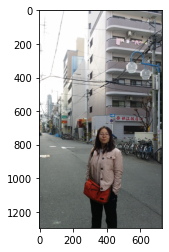

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/persion.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 시멘틱 세그멘테이션 - PixelLib 
  PASCAL VOC 데이터로 학습된 모델을 사용

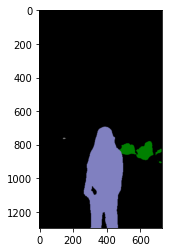

In [6]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용

# segvalues : class_ids(어떤 물체인지)와 masks 
# output : 세그멘테이션이 된 결과 ( BGR 순서)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [7]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bicycle
car
person


In [8]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

- 사람만 따로 이미지 출력

In [9]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
persion_color = (128,128,192) 

(1296, 730)


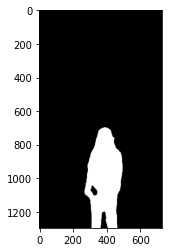

In [10]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==persion_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
# seg_color, seg_map은 RGB 형식
img_mask = seg_map.astype(np.uint8) * 255


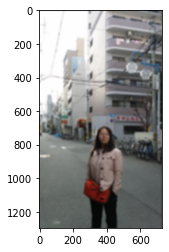

In [11]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
  cv2.bitwise_not(): 이미지가 반전
  cv2.bitwise_and(): 0인 픽셀(사람)은 모두 0이됨 --> 배경만 남음

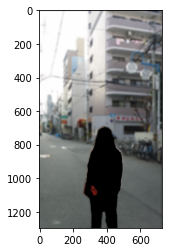

In [12]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (RGB(GRAY?)형식을 BGR 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 흐린 배경과 원본 영상 합성

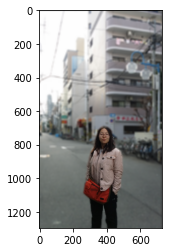

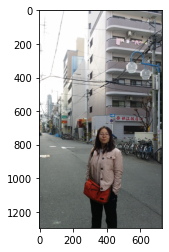

In [13]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다
# img_mask_color : 255(사람), 0(배경), BGR 형식
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 배경전환 크로마키 사진

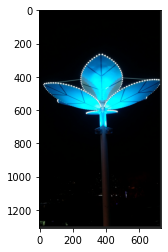

(1309, 732, 3)


In [14]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background_1.png'  
bg_img_orig = cv2.imread(bg_img_path) 
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()
print(bg_img_orig.shape)

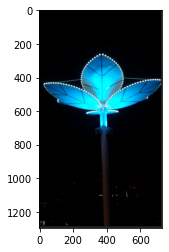

(1296, 730, 3)


In [15]:
# concat을 하려면, 두 이미지 size가 같아야 한다. 

bg_img = cv2.resize( bg_img_orig, (img_orig.shape[1], img_orig.shape[0]) )

plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
plt.show()
print(bg_img.shape)

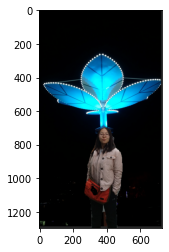

In [16]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다
# img_mask_color : 255(사람), 0(배경), BGR 형식
img_concat = np.where(img_mask_color==255, img_orig, bg_img)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


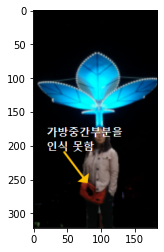

In [17]:
prob_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/persion_prob.png'  
prob_img = cv2.imread(prob_path) 
plt.imshow(cv2.cvtColor(prob_img, cv2.COLOR_BGR2RGB))
plt.show()

(780, 1376, 3)


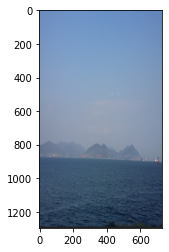

(1296, 730, 3)


In [18]:
sea_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background_see.png'  
sea_img_orig = cv2.imread(sea_img_path) 

print(sea_img_orig.shape)

sea_img = cv2.resize( sea_img_orig, (img_orig.shape[1], img_orig.shape[0]) )

plt.imshow(cv2.cvtColor(sea_img, cv2.COLOR_BGR2RGB))
plt.show()
print(sea_img.shape)

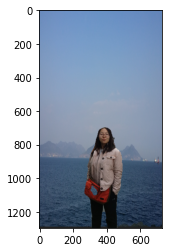

In [19]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다
# img_mask_color : 255(사람), 0(배경), BGR 형식
img_concat = np.where(img_mask_color==255, img_orig, sea_img)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 동물 사진

(1298, 968, 3)


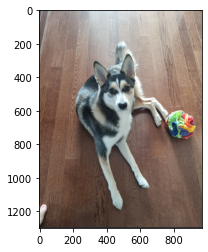

In [20]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

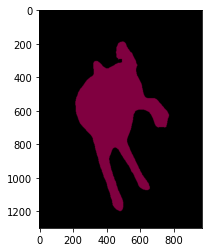

In [21]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용

# segvalues : class_ids(어떤 물체인지)와 masks 
# output : 세그멘테이션이 된 결과 ( BGR 순서)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [22]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [23]:
colormap[12] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 12번째인 개)

array([ 64,   0, 128])

(1298, 968)


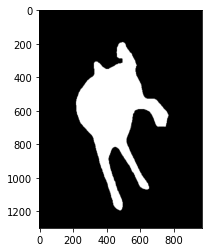

In [24]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
dog_color = (128,0,64) 

seg_map = np.all(output==dog_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
# seg_color, seg_map은 RGB 형식
img_mask = seg_map.astype(np.uint8) * 255

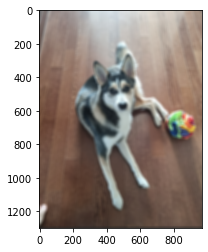

In [25]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (20,20))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

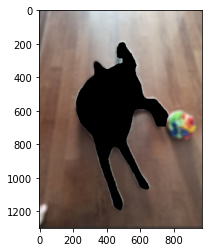

In [26]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (RGB(GRAY?)형식을 BGR 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 동물이 255 였으나
# 연산을 하고 나면 배경은 255 동물은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

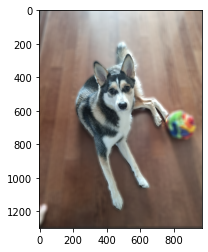

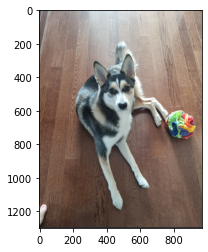

In [27]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다
# img_mask_color : 255(동물), 0(배경), BGR 형식
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

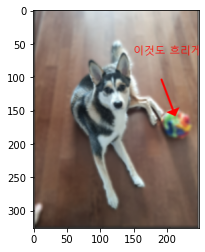

In [28]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog_outpocusing_prob.png'  
img_orig = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 솔루션 : 
 공모양 장난감도 물체로 인식하여, 배경으로 blur 처리 되지 않고 outpocusing 대상으로 처리
 -. 만약, pascal voc에서 공을 인식한다면, 공을 별도 이미지로 분리하고, ( dog+blur 배경 ) + 공 이미지를 concat하는 방식이 가능해보이는데, 
 -. CocoDetection에서 공에 대한 데이타 클래서로 처리해볼까?. 
 
 

In [33]:
from pixellib.instance import instance_segmentation
import os

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
coco_model_file = os.path.join(model_dir, 'mask_rcnn_coco.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.2/mask_rcnn_coco.h5'
# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, coco_model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/mask_rcnn_coco.h5',
 <http.client.HTTPMessage at 0x7acdfc722d60>)

In [43]:
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [72]:
from pixellib.instance import instance_segmentation
import os


# 1. 객체 분리기 설정
segment_image = instance_segmentation()
segment_image.load_model(coco_model_file)  # COCO 모델 로드

# 2. 분리 대상 클래스 정의
#target_classes = ["dog", "sports ball"]
target_classes = {
    "dog": True,
    "sports ball": True
}

# 3. 이미지 로드
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.png'  
img_orig = cv2.imread(img_path)

# 분리 실행
segmask, output = segment_image.segmentImage(
    img_path,
    segment_target_classes=target_classes,
    extract_segmented_objects=True,
    output_image_name="segmented_output.png"
)

# 분리된 마스크 이미지에서 색상 추출
seg_img = cv2.imread("segmented_output.png")
seg_img_rgb = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)

# 고유한 색상 추출
unique_colors = np.unique(seg_img_rgb.reshape(-1, 3), axis=0)

#print("🎨 추출된 색상 목록 (RGB):")
#for color in unique_colors:
#    print(tuple(color))

Processed image saved successfully in your current working directory.


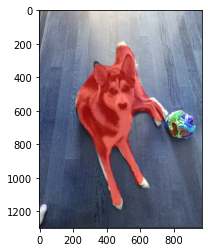

In [65]:
plt.imshow(output)
plt.show()

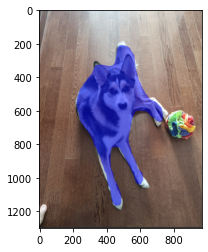

In [57]:
plt.imshow(seg_img_rgb)
plt.show()

In [59]:
if "instances" in segmask:
    for i, obj in enumerate(segmask["instances"]):
        print(f"Object {i+1}:")
        print("  Class:", obj["class"])
        print("  Box:", obj["box_points"])
        print("  Mask color:", obj["color"])
else:
    print("⚠️ 객체가 감지되지 않았거나, extract_segmented_objects=True가 아님.")

⚠️ 객체가 감지되지 않았거나, extract_segmented_objects=True가 아님.


In [60]:
import numpy as np

def create_pascal_colormap(num_classes=80):
    colormap = np.zeros((num_classes, 3), dtype=int)
    ind = np.arange(num_classes, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

coco_colormap = create_pascal_colormap(80)
print("dog (index 16):", coco_colormap[16])
print("sports ball (index 32):", coco_colormap[32])


dog (index 16): [ 0 64  0]
sports ball (index 32): [ 0  0 64]


In [70]:
# BGR -> RGB
dog_color = (0, 64, 0)

(1298, 968)


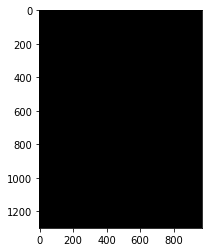

In [71]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다

seg_map = np.all(output==dog_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

[회고]
CocoDetection에는 데이타 클래스가 더 많긴 하지만, 장난감이 sports ball로는 인식되지 않았음
instance로 읽혀지지도 않았음